# Problem Statement

I was hired by ***greeting card company*** to classify whether or not a joke is a 'dad-joke'. Father's day is approaching; the company wants to run a dad-joke-based ad campaign. No one can agree on what consititutes a *dad-joke*. So, the goal of this project is to properly classify jokes as either 'dad-jokes' or 'standard jokes'.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC


Start by reading in the data:

In [3]:
df = pd.read_csv('./data/full.csv')

In [4]:
df.head()

,post,is_jokes
0,"A well-known professor of language, was caught...",1
1,"I'm quite a normal person, I'm very good frien...",1
2,How does a gypsy soccer match end? Without goals.,1
3,A granddaughters questions The first time our ...,1
4,What did the loaf of sourdough bread day to th...,1


I somehow ended up with null values after cleaning, so I just dropped them.

In [5]:
df.isna().sum()

post        156
is_jokes      0
dtype: int64

In [6]:
df.dropna(inplace=True)

In [7]:
df.isna().sum()

post        0
is_jokes    0
dtype: int64

In [8]:
df.head()

,post,is_jokes
0,"A well-known professor of language, was caught...",1
1,"I'm quite a normal person, I'm very good frien...",1
2,How does a gypsy soccer match end? Without goals.,1
3,A granddaughters questions The first time our ...,1
4,What did the loaf of sourdough bread day to th...,1


Here we define our null model accuracy of 51% (the majority class)

In [8]:
df.is_jokes.value_counts(normalize=True)

1    0.510128
0    0.489872
Name: is_jokes, dtype: float64

In [9]:
cvec = CountVectorizer(stop_words='english')

In [10]:
X = df.post
y = df.is_jokes

Train/test splitting, stratified on $y$, with standard split of 75/25

In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, random_state=6)

In [12]:
Xcv_train = cvec.fit_transform(X_train)
Xcv_test = cvec.transform(X_test)

In [13]:
Xcv_df = pd.DataFrame(Xcv_train.todense(), columns=cvec.get_feature_names())

In [14]:
Xcv_df.head()

,00,000,0038,00am,01,01am,02,05,07,0k,...,себя,странно,уши,что,чувствую,הזה,הצליח,הקפה,מי,נחמד
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Here we have the 25 most common words from our vectorized corpus:

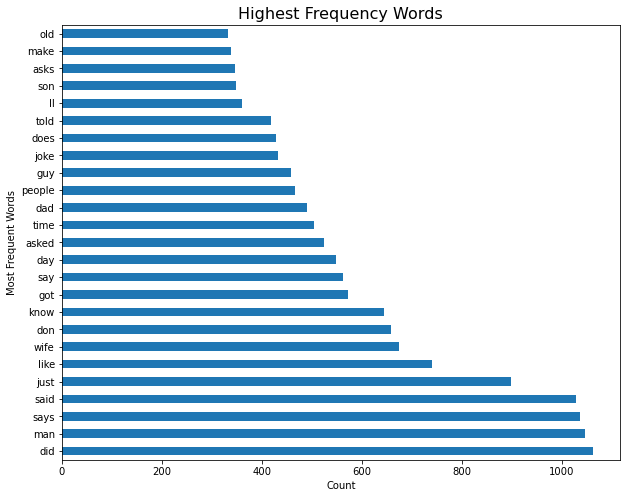

In [16]:
plt.figure(figsize=(10,8))
plt.title('Highest frequency words'.title(), fontdict={'fontsize': 16})
plt.xlabel('Count')
plt.ylabel('Most Frequent Words')
Xcv_df.sum().sort_values(ascending=False).head(25).plot(kind='barh');

In [16]:
Xcv_train.shape

(9256, 17392)

Grid searching over Logistic Regression hyperparameters with standard CountVectorizer:

In [17]:
params = {
    'penalty': ['l1', 'l2', 'elasticnet', 'none'],
    'solver': ['liblinear'],
    'C': np.linspace(0, 1, 100),
    'class_weight': ['balanced', None],
}

In [18]:
gs = GridSearchCV(LogisticRegression(), param_grid=params, n_jobs=-1, verbose=1)

In [19]:
gs.fit(Xcv_train, y_train)

Fitting 5 folds for each of 800 candidates, totalling 4000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 352 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done 2352 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:   23.7s finished


GridSearchCV(estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': array([0.        , 0.01010101, 0.02020202, 0.03030303, 0.04040404,
       0.05050505, 0.06060606, 0.07070707, 0.08080808, 0.09090909,
       0.1010101 , 0.11111111, 0.12121212, 0.13131313, 0.14141414,
       0.15151515, 0.16161616, 0.17171717, 0.18181818, 0.19191919,
       0.2020202 , 0.21212121, 0.22222222, 0.23232323, 0.24242424,
       0.252525...
       0.75757576, 0.76767677, 0.77777778, 0.78787879, 0.7979798 ,
       0.80808081, 0.81818182, 0.82828283, 0.83838384, 0.84848485,
       0.85858586, 0.86868687, 0.87878788, 0.88888889, 0.8989899 ,
       0.90909091, 0.91919192, 0.92929293, 0.93939394, 0.94949495,
       0.95959596, 0.96969697, 0.97979798, 0.98989899, 1.        ]),
                         'class_weight': ['balanced', None],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['liblinear']},
             verbose=1)

In [20]:
gs.score(Xcv_train, y_train), gs.score(Xcv_test, y_test)

(0.7371434745030251, 0.6458198314970836)

Grid Searching over CountVectorizer and LogisticRegression:

In [21]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('lr', LogisticRegression())
])

In [22]:
pparams = {
    'cvec__max_features': [5000, 6500, 8000, 9500],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'lr__penalty': ['l1', 'l2', 'none'],
    'lr__solver': ['liblinear'],
    'lr__C': np.linspace(0, 1, 20),
    'lr__class_weight': ['balanced', None]
}

In [23]:
gs2 = GridSearchCV(pipe, param_grid=pparams, n_jobs=-1, verbose=1)

In [24]:
gs2.fit(X_train, y_train)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.


Fitting 5 folds for each of 8640 candidates, totalling 43200 fits


[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.8s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   32.2s
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1768 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 2418 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 3168 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 4018 tasks      | elapsed:  5.7min
[Parallel(n_jobs=-1)]: Done 4968 tasks      | elapsed:  7.1min
[Parallel(n_jobs=-1)]: Done 6018 tasks      | elapsed:  8.5min
[Parallel(n_jobs=-1)]: Done 7168 tasks      | elapsed: 10.9min
[Parallel(n_jobs=-1)]: Done 8418 tasks      | elapsed: 12.2min
[Parallel(n_jobs=-1)]: Done 9768 tasks      | elapsed: 14.3min
[Parallel(n_jobs=-1)]: Done 11218 tasks      | elapsed: 16.7min
[Parallel(n_jobs=-1)]: Done 12768 tasks      | elapsed: 19

GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('lr', LogisticRegression())]),
             n_jobs=-1,
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [5000, 6500, 8000, 9500],
                         'cvec__min_df': [1, 2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2), (1, 3)],
                         'lr__C': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ]),
                         'lr__class_weight': ['balanced', None],
                         'lr__penalty': ['l1', 'l2', 'none'],
                         'lr__solver': ['liblinear']},
             verbose=1)

In [25]:
gs2.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 9500,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2),
 'lr__C': 0.05263157894736842,
 'lr__class_weight': 'balanced',
 'lr__penalty': 'l2',
 'lr__solver': 'liblinear'}

In [26]:
gs2.best_score_

0.6328882992440021

In [55]:
gs2.score(X_train, y_train), gs2.score(X_test, y_test)

(0.7689066551426103, 0.644199611147116)

Random searching over CountVectorizer and K-Nearest Neighbors:

In [27]:
pipe2 = Pipeline([
    ('cvec', CountVectorizer()),
    ('knn', KNeighborsClassifier())
])

In [66]:
pparams2 = {
    'cvec__max_features': [5000, 6500, 8000, 9500],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': ['english', None],
    'knn__n_neighbors': list(range(1, 16, 2)),
    'knn__weights': ['uniform', 'distance'],
    'knn__p': [1,2,3]
}

In [67]:
rs = RandomizedSearchCV(pipe2, param_distributions=pparams2, n_iter=250, 
                        n_jobs=-1, cv=5, random_state=6, verbose=1)

In [68]:
rs.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:   24.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   59.1s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  3.0min finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('knn', KNeighborsClassifier())]),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'cvec__max_df': [0.9, 0.95],
                                        'cvec__max_features': [5000, 6500, 8000,
                                                               9500],
                                        'cvec__min_df': [1, 2, 3],
                                        'cvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3)],
                                        'cvec__stop_words': ['english', None],
                                        'knn__n_neighbors': [1, 3, 5, 7, 9, 11,
                                                             13, 15],
                                        'knn__p': [1, 2, 3],
                                        'knn__weights

In [31]:
rs.best_params_

{'knn__weights': 'uniform',
 'knn__p': 2,
 'knn__n_neighbors': 3,
 'cvec__ngram_range': (1, 1),
 'cvec__min_df': 2,
 'cvec__max_features': 6500,
 'cvec__max_df': 0.95}

In [32]:
rs.best_score_

0.5643906218458763

In [33]:
y.value_counts(normalize=True)

1    0.510128
0    0.489872
Name: is_jokes, dtype: float64

In [34]:
MultinomialNB()

MultinomialNB()

Random search over CountVectorizer and MultinomialNaiveBayes

In [35]:
pipe3 = Pipeline([
    ('cvec', CountVectorizer()),
    ('mnb', MultinomialNB())
])

In [69]:
pparams3 = {
    'cvec__max_features': [5000, 6500, 8000, 9500],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__stop_words': ['english', None],
    'mnb__alpha': np.linspace(0, 1, 20)
}

In [70]:
rs2 = RandomizedSearchCV(pipe3, param_distributions=pparams3, n_iter=200, n_jobs=-1, verbose=1, cv=5)

In [71]:
rs2.fit(X_train, y_train)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:    0.6s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:    4.3s
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1000 out of 1000 | elapsed:   24.6s finished


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('mnb', MultinomialNB())]),
                   n_iter=200, n_jobs=-1,
                   param_distributions={'cvec__max_df': [0.9, 0.95],
                                        'cvec__max_features': [5000, 6500, 8000,
                                                               9500],
                                        'cvec__min_df': [1, 2, 3],
                                        'cvec__stop_words': ['english', None],
                                        'mnb__alpha': array([0.        , 0.05263158, 0.10526316, 0.15789474, 0.21052632,
       0.26315789, 0.31578947, 0.36842105, 0.42105263, 0.47368421,
       0.52631579, 0.57894737, 0.63157895, 0.68421053, 0.73684211,
       0.78947368, 0.84210526, 0.89473684, 0.94736842, 1.        ])},
                   verbose=1)

In [39]:
rs2.best_params_

{'mnb__alpha': 1.0,
 'cvec__min_df': 1,
 'cvec__max_features': 9500,
 'cvec__max_df': 0.9}

In [40]:
rs2.best_score_

0.6130086124714561

Random search with CountVectorizer and RandomForestClassifier:

In [27]:
pipe4 = Pipeline([
    ('cvec', CountVectorizer()),
    ('rf', RandomForestClassifier())
])

pparams4 = {
    'cvec__max_features': [3500, 5000, 6500, 8000, 9500],
    'cvec__min_df': [1, 2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2), (1,3)],
    'cvec__stop_words': ['english', None],
    'rf__n_estimators': [500, 750, 1000, 1250, 1500],
    'rf__max_depth': [15, 17, 19, 21, 23, 25],
    'rf__min_samples_split': [3, 4, 5],
    'rf__min_samples_leaf': [2, 3, 4],
    'rf__max_features': ['auto']
}

In [28]:
rs3 = RandomizedSearchCV(pipe4, param_distributions=pparams4, n_iter=250, n_jobs=-1, verbose=1)

In [29]:
rs3.fit(X_train, y_train)

Fitting 5 folds for each of 250 candidates, totalling 1250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 16 concurrent workers.
[Parallel(n_jobs=-1)]: Done  18 tasks      | elapsed:   10.8s
[Parallel(n_jobs=-1)]: Done 168 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 418 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 768 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 1218 tasks      | elapsed:  9.2min
[Parallel(n_jobs=-1)]: Done 1250 out of 1250 | elapsed:  9.4min finished


RandomizedSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                             ('rf', RandomForestClassifier())]),
                   n_iter=250, n_jobs=-1,
                   param_distributions={'cvec__max_df': [0.9, 0.95],
                                        'cvec__max_features': [3500, 5000, 6500,
                                                               8000, 9500],
                                        'cvec__min_df': [1, 2, 3],
                                        'cvec__ngram_range': [(1, 1), (1, 2),
                                                              (1, 3)],
                                        'cvec__stop_words': ['english', None],
                                        'rf__max_depth': [15, 17, 19, 21, 23,
                                                          25],
                                        'rf__max_features': ['auto'],
                                        'rf__min_samples_leaf': [2, 3, 

In [44]:
rs3.best_params_

{'rf__n_estimators': 1000,
 'rf__min_samples_split': 4,
 'rf__min_samples_leaf': 2,
 'rf__max_features': 'auto',
 'rf__max_depth': 25,
 'cvec__ngram_range': (1, 1),
 'cvec__min_df': 1,
 'cvec__max_features': 5000,
 'cvec__max_df': 0.95}

In [45]:
rs3.best_score_

0.6305119058870752

In [46]:
rs3.score(X_train, y_train), rs3.score(X_test, y_test)

(0.719533275713051, 0.636746597537265)

This would have been random searching over CountVec with XGBoost/SupportVectorClassifier, but the searches were taking way too long and I was running out of time. I plan to come back and rerun these searches, as well as trying other models and NLP tools.

In [47]:
pipe5 = Pipeline([
    ('cvec', CountVectorizer()),
    ('xgb', XGBClassifier())
])

In [48]:
# XGBClassifier()

In [49]:
# pparams5 = {
#     'cvec__max_features': [3500, 5000, 6500, 8000, 9500],
#     'cvec__min_df': [1, 2, 3],
#     'cvec__max_df': [.9, .95],
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)],
#     'xgb__n_estimators': [50, 100, 200, 300, 400],
#     'xgb__max_depth': [2,3,4,5,7,9,15],
#     'xgb__learning_rate': np.linspace(0, 1, 10),
#     'xgb__booster': ['gbtree', 'gblinear', 'dart'],
#     'xgb__gamma': np.linspace(0, 3, 10)
# }

In [50]:
# rs5 = RandomizedSearchCV(pipe5, pparams5, n_iter=100, n_jobs=-1, verbose=3)

In [51]:
# rs5.fit(X_train, y_train)

In [52]:
# pipe6 = Pipeline([
#     ('cvec', CountVectorizer()),
#     ('svc', SVC())
# ])
# pparams6 = {
#     'cvec__max_features': [3500, 5000, 6500, 8000, 9500],
#     'cvec__min_df': [1, 2, 3],
#     'cvec__max_df': [.9, .95],
#     'cvec__ngram_range': [(1,1), (1,2), (1,3)],
#     'svc__C': np.logspace(-3, 3, 100),
#     'svc__kernel': ['linear', 'poly', 'rbf', 'sigmoid', 'precomputed'],
#     'svc__degree': [2,3,4],
#     'svc__gamma': ['scale', 'auto']
# }

In [53]:
# rs6 = RandomizedSearchCV(pipe6, pparams6, n_jobs=-1, n_iter=100, verbose=1)

In [54]:
# rs6.fit(X_train, y_train)

Here we have our top 3 models, their parameters, and train/test accuracy scores:

| KNN | LR | RFC |
|---|---|---|
| weights: uniform | C: 0.05 | n_estimators: 750 |
| p: 2 | class_weight: balanced | min_samples_split: 4 |
| n_neighbors: 7 | penalty: L2 | min_samples_leaf: 3 |
| - | solver: liblinear | max_features: auto |
|-|-| max_depth: 25 |
|-|-|-|
| cvec__stop_words: None | cvec__stop_words: english | cvec__stop_words: None |
| cvec__ngram_range: (1, 3) | - | cvec__ngram_range: (1, 1) |
| cvec__min_df: 1 | - | cvec__min_df: 3 |
| cvec__max_df: .95 | - | cvec__max_df: 0.9 |
| cvec__max_features: 5,000 | - | cvec__max_features: 5,000 |
|-|-|-|
| **Train** | **Train** | **Train** |
| 0.6646 | 0.7371 | 0.6990 |
| **Test** | **Test** | **Test** |
| 0.5531 | 0.6458 | 0.6367 |

In [89]:
for model in [rs,rs3]:
    print(model.best_params_,'\n', model.score(X_train, y_train), model.score(X_test, y_test),'\n', (model.score(X_train, y_train) - model.score(X_test, y_test)), '\n')

{'knn__weights': 'uniform', 'knn__p': 2, 'knn__n_neighbors': 7, 'cvec__stop_words': None, 'cvec__ngram_range': (1, 3), 'cvec__min_df': 1, 'cvec__max_features': 5000, 'cvec__max_df': 0.95} 
 0.6646499567847882 0.5531432274789372 
 0.11150672930585104 

{'rf__n_estimators': 750, 'rf__min_samples_split': 4, 'rf__min_samples_leaf': 3, 'rf__max_features': 'auto', 'rf__max_depth': 25, 'cvec__stop_words': None, 'cvec__ngram_range': (1, 1), 'cvec__min_df': 3, 'cvec__max_features': 5000, 'cvec__max_df': 0.9} 
 0.6990060501296457 0.636746597537265 
 0.06225945259238064 



In [63]:
print(gs.best_params_,'\n', gs.score(Xcv_train, y_train), gs.score(Xcv_test, y_test),'\n', (gs.score(Xcv_train, y_train) - gs.score(Xcv_test, y_test)), '\n')

{'C': 0.05050505050505051, 'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'} 
 0.7371434745030251 0.6458198314970836 
 0.09132364300594153 



In [55]:
rs3_hat = rs3.predict(X_test)

In [81]:
tn, fp, fn, tp = confusion_matrix(y_test, rs3_hat).ravel()

In [85]:
def scores(tn, fp, fn, tp):
    spec = tn / (tn+fp)
    sens = tp/(tp+fn)
    acc = (tn+tp)/(tn+tp+fn+fp)
    prec = tp / (tp+fp)
    f1 = 2*((prec*sens)/(prec+sens))
    bacc = (sens + spec) / 2
    print(f'''
    Accuracy: {acc}
    Precision: {prec}
    Sensitivity: {sens}
    Specificity: {spec}
    F1 Score: {f1}
    Balanced Accuracy: {bacc}
    ''')

In [86]:
scores(tn, fp, fn, tp)


    Accuracy: 0.636746597537265
    Precision: 0.7267267267267268
    Sensitivity: 0.46124523506988563
    Specificity: 0.8194444444444444
    F1 Score: 0.5643218033424018
    Balanced Accuracy: 0.640344839757165
    


In [87]:
rs_hat = rs.predict(X_test)
tn, fp, fn, tp = confusion_matrix(y_test, rs_hat).ravel()
scores(tn, fp, fn, tp)


    Accuracy: 0.5531432274789372
    Precision: 0.6077348066298343
    Sensitivity: 0.34942820838627703
    Specificity: 0.7652116402116402
    F1 Score: 0.4437273093989512
    Balanced Accuracy: 0.5573199242989586
    


In [88]:
gs_hat = gs.predict(Xcv_test)
tn, fp, fn, tp = confusion_matrix(y_test, gs_hat).ravel()
scores(tn, fp, fn, tp)


    Accuracy: 0.6458198314970836
    Precision: 0.715695067264574
    Sensitivity: 0.5069885641677255
    Specificity: 0.7903439153439153
    F1 Score: 0.5935291930085533
    Balanced Accuracy: 0.6486662397558205
    


In [90]:
df.head()

,post,is_jokes
0,"A well-known professor of language, was caught...",1
1,"I'm quite a normal person, I'm very good frien...",1
2,How does a gypsy soccer match end? Without goals.,1
3,A granddaughters questions The first time our ...,1
4,What did the loaf of sourdough bread day to th...,1


In [12]:
Xcv_df['is_jokes'] = df.is_jokes

In [98]:
Xcv_df.groupby('is_jokes').mean()

,00,000,0038,00am,01,01am,02,05,07,0k,...,себя,странно,уши,что,чувствую,הזה,הצליח,הקפה,מי,נחמד
is_jokes,,,,,,,,,,,,,,,,,,,,,
0.0,0.002826,0.007418,0.000000,0.000000,0.000000,0.000353,0.000000,0.000353,0.000353,0.000000,...,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353,0.000353
1.0,0.000635,0.003018,0.000159,0.000159,0.000318,0.000159,0.000318,0.000000,0.000000,0.000159,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


Here I looked at the top 40 words from each subreddit, and specifically pulled out the unique words from each: 

| Jokes | DadJokes |
|-|-|
|right|think|
|goes|little|
|didn't|doctor|
|today|came|

In [20]:
a = Xcv_df[Xcv_df['is_jokes'] == 1].sum().sort_values(ascending=False).head(41)[1:]

In [21]:
b = Xcv_df[Xcv_df['is_jokes'] == 0].sum().sort_values(ascending=False).head(40)

In [22]:
a

said      709.0
did       697.0
says      687.0
man       660.0
just      604.0
like      508.0
wife      466.0
don       440.0
know      425.0
say       386.0
got       384.0
asked     349.0
day       346.0
time      330.0
guy       322.0
dad       317.0
joke      307.0
people    305.0
does      298.0
told      297.0
son       251.0
ll        250.0
make      241.0
asks      239.0
new       229.0
going     229.0
old       220.0
ve        218.0
went      207.0
good      202.0
friend    201.0
want      200.0
really    200.0
bar       188.0
right     188.0
tell      178.0
goes      177.0
didn      177.0
woman     176.0
today     174.0
dtype: float64

In [23]:
b

man       356.0
did       344.0
says      339.0
said      310.0
just      275.0
like      227.0
don       215.0
know      214.0
day       198.0
wife      198.0
got       183.0
time      170.0
say       167.0
dad       166.0
asked     164.0
people    156.0
guy       134.0
does      125.0
joke      120.0
told      117.0
bar       110.0
old       108.0
think     107.0
ll        104.0
woman     102.0
asks       98.0
little     98.0
son        97.0
want       94.0
make       94.0
good       94.0
going      94.0
went       91.0
new        90.0
doctor     87.0
ve         86.0
came       85.0
friend     84.0
really     81.0
tell       80.0
dtype: float64

In [24]:
[(i, index) for index, i in enumerate(a.index) if i not in b.index]

[('right', 34), ('goes', 36), ('didn', 37), ('today', 39)]

In [25]:
[(i, index) for index, i in enumerate(b.index) if i not in a.index]

[('think', 22), ('little', 26), ('doctor', 34), ('came', 36)]

In [123]:
df.is_jokes.value_counts(), df.is_jokes.value_counts(normalize=True)

(1    6296
 0    6046
 Name: is_jokes, dtype: int64,
 1    0.510128
 0    0.489872
 Name: is_jokes, dtype: float64)

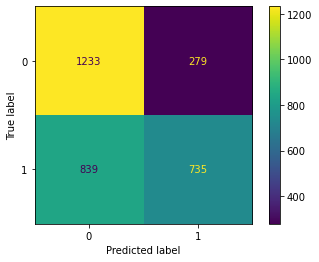

In [30]:
plot_confusion_matrix(rs3, X_test, y_test)

In [41]:
rs3.best_estimator_


Pipeline(steps=[('cvec',
                 CountVectorizer(max_df=0.95, max_features=5000, min_df=3)),
                ('rf',
                 RandomForestClassifier(max_depth=25, min_samples_leaf=3,
                                        min_samples_split=4,
                                        n_estimators=1500))])

In [53]:
list(zip(Xcv_df.columns, rs3.best_estimator_.named_steps['rf'].feature_importances_)).sort(key=rs3.best_estimator_.named_steps['rf'].feature_importances_)


TypeError: 'numpy.ndarray' object is not callable

In [54]:
from sklearn.metrics import roc_auc_score

In [56]:
roc_auc_score(y_test, rs3_hat)

0.641219670841653

# Conclusion

In summary, I think that this project is a good proof of concept. It shows that with the right data and appropriate modeling, classification *is* possible here. As it stands now, I would recommend the company use the RandomForestClassifier model, as it performed the best (of the models we tried) with regard to accuracy and bias/variance. In the future, I plan on revisiting this problem with more robust modeling techniques and NLP tools to try to improve model performance.